In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision.datasets import MNIST, ImageFolder
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset

import random
from PIL import Image
import PIL.ImageOps

import pandas as pd
import torch.nn.functional as F
import torch.utils.data as utils
from torch.utils.data import DataLoader, Dataset
from utils import imshow, show_plot
from torch.autograd import Variable
import os
from tqdm import tqdm

### Contrastive Loss(대조 손실)

In [2]:
class ContrastiveLoss(torch.nn.Module):
    
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

### 샴네트워크 아키텍처 구성

In [3]:
# 샴네트워크 아키텍처 구성
class SiameseNetwork(nn.Module):
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        
        # Setting up the Sequential of CNN Layers
        self.cnn1 = nn.Sequential(
            nn.Conv2d(1, 96, kernel_size=11,stride=1),
            nn.BatchNorm2d(96),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            
            nn.Conv2d(96, 256, kernel_size=5,stride=1,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            #nn.LocalResponseNorm(5,alpha=0.0001,beta=0.75,k=2),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

            nn.Conv2d(256,384 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(inplace=True),
            
            nn.Conv2d(384,256 , kernel_size=3,stride=1,padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(3, stride=2),
            nn.Dropout2d(p=0.3),

        )
        
        # Defining the fully connected layers
        self.fc1 = nn.Sequential(
            nn.Linear(30976, 1024),
            nn.ReLU(inplace=True),
            nn.Dropout2d(p=0.5),
            
            nn.Linear(1024, 128),
            nn.ReLU(inplace=True),
            
            nn.Linear(128,2))
  
    def forward_once(self, x):
        # Forward pass 
        output = self.cnn1(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        # forward pass of input 1
        output1 = self.forward_once(input1)
        # forward pass of input 2
        output2 = self.forward_once(input2)
        return output1, output2

### 데이터로드

In [4]:
class SiameseNetworkDataset(Dataset):
    def __init__(self,imageFolderDataset,transform=None,should_invert=True):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.should_invert = should_invert
        
    def __getitem__(self, index):
        img0_tuple = random.choice(self.imageFolderDataset.imgs)
        # 약 50%의 확률로 같은 클래스 이미지를 선택할지, 다른 클래스 이미지를 선택할지를 결정
        should_get_same_class = random.randint(0,1) 
        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        
        if self.should_invert:
            img0 = PIL.ImageOps.invert(img0)
            img1 = PIL.ImageOps.invert(img1)

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return (img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32)))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [5]:
# 데이터 폴더 경로 설정
data_folder = './database/train'

# 이미지 변환 설정
transform = transforms.Compose(
    [transforms.Resize((105, 105)), transforms.ToTensor()]
)

# 이미지 폴더 데이터셋 생성
dataset = ImageFolder(data_folder, transform=transform)  # transform은 SiameseNetworkDataset에서 수행

# SiameseNetworkDataset 생성
train_dataloader = SiameseNetworkDataset(imageFolderDataset=dataset, transform=transform)

### 학습

In [6]:
net = SiameseNetwork()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, weight_decay=0.0005)
epochs=20

def train(train_dataloader, epoch):
    loss=[] 
    counter=[]
    iteration_number = 0

    for i, data in tqdm(enumerate(train_dataloader,0), total=len(train_dataloader), desc=f"Epoch {epoch}/{epochs}"):
        if i >= len(train_dataloader):
            break
        img0, img1 , label = data
        img0 = torch.unsqueeze(img0, 1)  # Add channel dimension
        img1 = torch.unsqueeze(img1, 1)  # Add channel dimension
        optimizer.zero_grad()
        output1,output2 = net(img0, img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()
        loss.append(loss_contrastive.item())

    loss = np.array(loss)
    return loss.mean()/len(train_dataloader)

def eval(eval_dataloader):
    loss=[] 
    counter=[]
    iteration_number = 0
    for i, data in enumerate(eval_dataloader,0):
        img0, img1 , label = data
        img0 = torch.unsqueeze(img0, 1)  # Add channel dimension
        img1 = torch.unsqueeze(img1, 1)  # Add channel dimension
        output1,output2 = net(img0, img1)
        loss_contrastive = criterion(output1, output2, label)
        loss.append(loss_contrastive.item())
    loss = np.array(loss)
    return loss.mean()/len(eval_dataloader)

for epoch in range(1, 20):
    best_eval_loss = 9999
    train_loss = train(train_dataloader, epoch)

    print(f"Current loss {train_loss}")

    torch.save(net.state_dict(), "best.pt")
    # eval_loss = eval(eval_dataloader)

    # print(f"Training loss{train_loss}")
    # print("-"*20)
    # print(f"Eval loss{eval_loss}")

    # if eval_loss<best_eval_loss:
    #     best_eval_loss = eval_loss
    #     print("-"*20)
    #     print(f"Best Eval loss{best_eval_loss}")
    #     torch.save(net.state_dict(), "best.pt")
    #     print("Model Saved Successfully") 

Epoch 1/20:   0%|          | 0/30 [00:00<?, ?it/s]c:\Users\User\anaconda3\envs\py3.8\lib\site-packages\torch\nn\functional.py:1331: UserWarning: dropout2d: Received a 2-D input to dropout2d, which is deprecated and will result in an error in a future release. To retain the behavior and silence this warning, please use dropout instead. Note that dropout2d exists to provide channel-wise dropout on inputs with 2 spatial dimensions, a channel dimension, and an optional batch dimension (i.e. 3D or 4D inputs).
  warnings.warn(warn_msg)
Epoch 1/20: 100%|██████████| 30/30 [00:47<00:00,  1.58s/it]


Current loss 8.831109779675803


Epoch 2/20: 100%|██████████| 30/30 [00:49<00:00,  1.66s/it]


Current loss 1.6149144352806941


Epoch 3/20: 100%|██████████| 30/30 [00:52<00:00,  1.74s/it]


Current loss 2.386078684065077


Epoch 4/20: 100%|██████████| 30/30 [00:35<00:00,  1.18s/it]


Current loss 1.6680096467336019


Epoch 5/20: 100%|██████████| 30/30 [00:33<00:00,  1.12s/it]


Current loss 0.49884902214424476


Epoch 6/20: 100%|██████████| 30/30 [00:29<00:00,  1.01it/s]


Current loss 0.3084869189932942


Epoch 7/20: 100%|██████████| 30/30 [00:28<00:00,  1.04it/s]


Current loss 0.21223125823669964


Epoch 8/20:  43%|████▎     | 13/30 [00:14<00:19,  1.15s/it]


KeyboardInterrupt: 

### 테스트

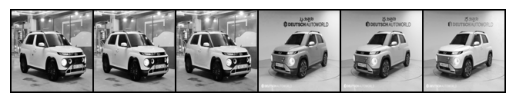

Predicted Eucledian Distance:- tensor([0.1553, 0.0959, 0.0931], grad_fn=<NormBackward1>)


In [ ]:
model = SiameseNetwork()
model.load_state_dict(torch.load("best.pt"))
model.eval()  # Set the model to evaluation mode
device = torch.device('cpu')

totensor = transforms.ToTensor()

x0 = totensor(Image.open('./database/test/hyundai+casper/test.jpg').resize((105, 105)))
x1 = totensor(Image.open('./database/test/hyundai+casper/test2.jpg').resize((105, 105)))

x0 = torch.unsqueeze(x0, 1)  # Add channel dimension
x1 = torch.unsqueeze(x1, 1)  # Add channel dimension
output1, output2 = model(x0.to(device), x1.to(device))

eucledian_distance = F.pairwise_distance(output1, output2)

concat = torch.cat((x0, x1), 0)
imshow(torchvision.utils.make_grid(concat))
print("Predicted Eucledian Distance:-", eucledian_distance)